In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.datasets import fetch_openml 

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from openTSNE.sklearn import TSNE as O_TSNE

from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

np.random.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 9)

# Etude 1 - PCA

Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next evaluate the classifier on the test set: how does it compare to the previous classifier?

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)
X, y = mnist["data"], mnist["target"]

Let's split the data into the training and testing sets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000)

Let's train a Random Forest classifier and see how long will it take.

In [5]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [6]:
%%time
rf_clf.fit(X_train, y_train)

Wall time: 41.1 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [7]:
rf_clf.score(X_test, y_test)

0.9674

Let's reduce the dataset's dimensionality.

In [8]:
pca = PCA(n_components=0.95)

In [9]:
X_train_reduced = pca.fit_transform(X_train)

In [10]:
%%time
rf_clf.fit(X_train_reduced, y_train)

Wall time: 44.8 s


RandomForestClassifier(n_jobs=-1, random_state=42)

Unfortunately, we did not improve the performance considerably by applying the PCA. Note that we should only use the transform(), not fit() method. 

In [11]:
X_test_reduced = pca.transform(X_test)

In [12]:
rf_clf.score(X_test_reduced, y_test)

0.9469

The accuracy score after applying the PCA is reduced. Let's try an SVC.

In [13]:
from sklearn.svm import LinearSVC
svc_clf = LinearSVC()

In [14]:
%%time
svc_clf.fit(X_train, y_train)

Wall time: 3min 7s


C:\Users\CS\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

In [15]:
svc_clf.score(X_test, y_test)

0.8535

In [16]:
%%time
svc_clf.fit(X_train_reduced, y_train)

Wall time: 8min 6s


C:\Users\CS\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

In [17]:
svc_clf.score(X_test_reduced, y_test)

0.8009

Surprisingly, the training time has increased considerably for SVC after applying the PCA. Possible explanation: "If you are using PCA to significantly reduce dimensionality before running SVM, this can impair SVM. You might want to retain more dimensions so that SVM retains more information." (from https://www.researchgate.net/post/Is_there_a_specific_reason_that_using_PCA_gives_worse_results_than_without_using_it_in_SVM_classification).

Let's try this on SGD classifier.

In [18]:
from sklearn.linear_model import SGDClassifier
reg_clf = SGDClassifier(random_state=42, n_jobs=-1)

In [19]:
%%time
reg_clf.fit(X_train, y_train)

Wall time: 1min 8s


SGDClassifier(n_jobs=-1, random_state=42)

In [20]:
reg_clf.score(X_test, y_test)

0.8691

In [21]:
%%time
reg_clf.fit(X_train_reduced, y_train)

Wall time: 15.1 s


SGDClassifier(n_jobs=-1, random_state=42)

In [22]:
reg_clf.score(X_test_reduced, y_test)

0.8907

The training speed has increased significantly. Moreover, the classifier's accuracy has increased too. One of the explanations of the increased accuracy is that the model was overfitting when using SGD, and applying the PCA reduced the overfitting.
Note from Scikit-Learn documentation: "If you apply SGD to features extracted using PCA we found that it is often wise to scale the feature values by some constant c such that the average L2 norm of the training data equals one." (from here: https://scikit-learn.org/stable/modules/sgd.html). Thereby, maybe we should apply regularization to SGD.

# Etude 2 - Dimensionality Reduction

Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

In [23]:
idx_shuffle = np.random.permutation(10000)

In [24]:
X_red = mnist["data"][idx_shuffle, :]
y_red = mnist["target"][idx_shuffle]

Let's make sure that the numbers in the reduced dataset are distributed approximately uniformly.

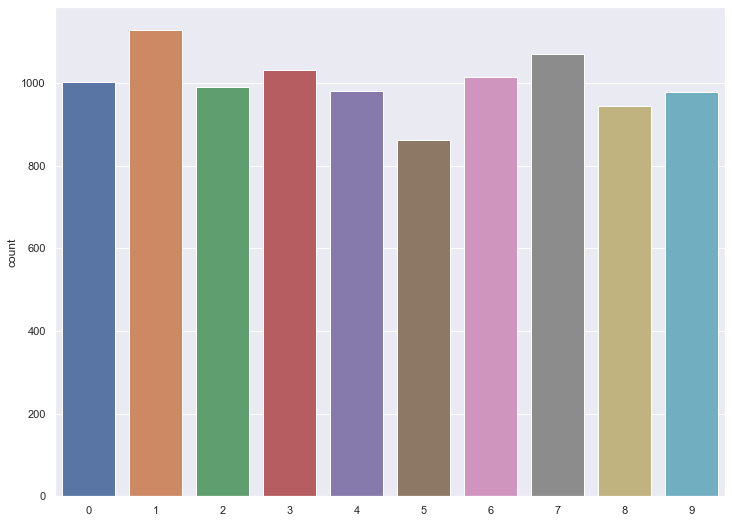

In [25]:
# V1
sns.countplot(y_red);

In [26]:
# # V2
# unique, counts = np.unique(y_red, return_counts=True)
# plt.bar(unique, counts, tick_label = unique);

In [27]:
# # V3
# cnt = np.bincount(y_red)
# ii = np.flatnonzero(cnt)

# plt.bar(ii, cnt, tick_label = ii);

Let's write a function that will plot the scatterplots with numbers on them.

In [28]:
def plot_digits(X, y):
    """Plots clusters with numbers on them"""
    digits = np.unique(y)
    palette_digits = sns.color_palette('bright', n_colors=len(digits))
    ax = sns.scatterplot(X[: , 0], X[:, 1], hue=y, palette=palette_digits, legend=False)
    x_mean_list = [] 
    
    for index, digit in enumerate(digits):
        x_mean = np.mean(X[(y == digit) , 0])
        y_mean = np.mean(X[(y == digit) , 1])
        
        # if the label overlaps with another label (their X coordinates are close), move it 5 points
        for mean in x_mean_list:
            if (np.linalg.norm(mean - x_mean) < 5):
                x_mean = x_mean + 7
       
        x_mean_list.append(x_mean)
                                 
        ax.annotate(digit,
                    xy=(x_mean, y_mean),
                    horizontalalignment='center',
                    verticalalignment='center',
                    size=22,
                    color='white',
                    backgroundcolor=palette_digits[digit],
                   )
    plt.show()

## t-SNE

First let's apply t-SNE to our reduced dataset.

In [29]:
t_sne = TSNE(n_jobs=-1)

In [30]:
%%time
X_red_embedded = t_sne.fit_transform(X_red)

Wall time: 2min 14s


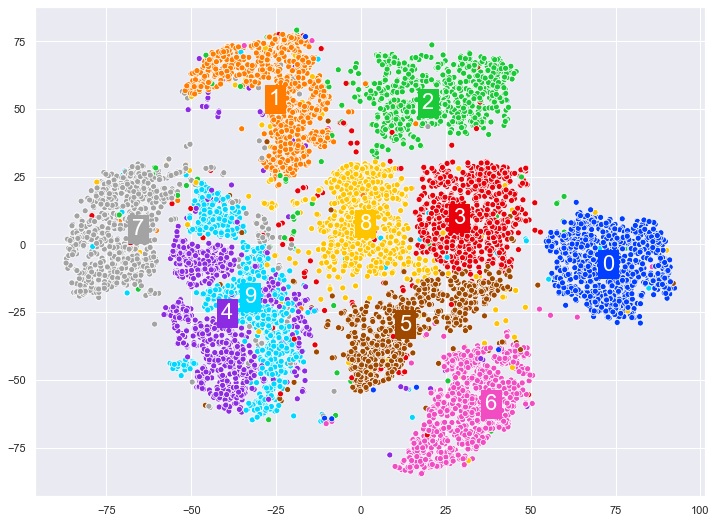

In [31]:
plot_digits(X_red_embedded, y_red)

## t-SNE after PCA

Note that our dataset has 784 dimensions. The documentation where TSNE is described states the following: "It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples."
<br>So let's try to reduce the number of dimensions to 50 on a reduced dataset and then apply TSNE again.

In [32]:
pca = PCA(n_components=50)

In [33]:
X_after_PCA = pca.fit_transform(X_red)

In [34]:
%%time
X_PCA_embedded = t_sne.fit_transform(X_after_PCA)

Wall time: 1min 23s


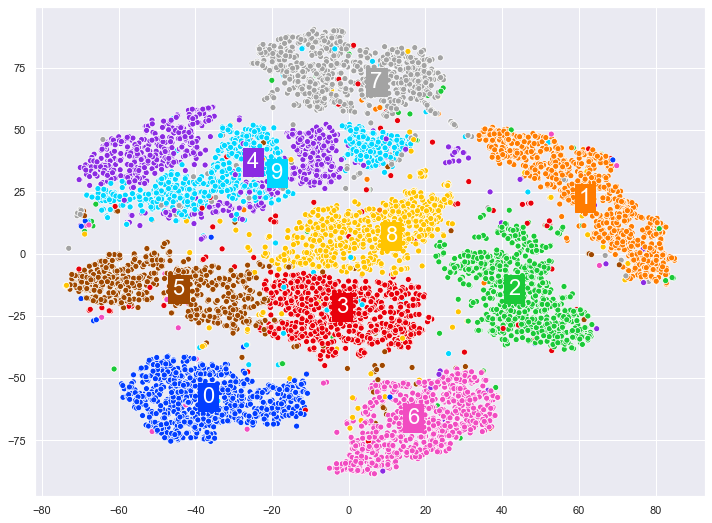

In [35]:
plot_digits(X_PCA_embedded, y_red)

Looks like after applying the PCA clusters are better separated.

## openTSNE

Also let's try the openTSNE library that promises performance improvements. 

In [36]:
open_tsne = O_TSNE(n_jobs=-1)

In [37]:
%%time
X_red_embedded_otsne = open_tsne.fit_transform(X_red)

Wall time: 1min 36s


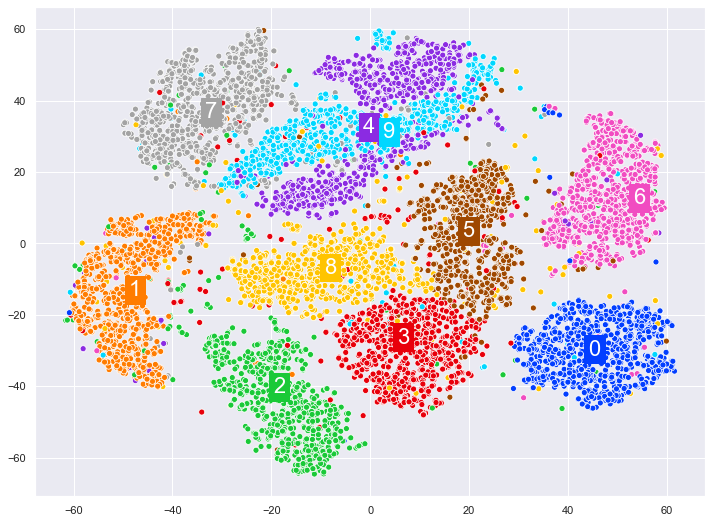

In [38]:
plot_digits(X_red_embedded_otsne, y_red)

We can conclude that the PCA + t-SNE produced the clusters that are better separated from each other, and that the OpenTSNE implementation is indeed the fastest.